### Predictive model using Support Vector Machine (SVM)

Support vector machines (SVMs) learning algorithm will be used to build the predictive model.  SVMs are one of the most popular classification algorithms, and have an elegant way of transforming nonlinear data so that one can use a linear algorithm to fit a linear model to the data (Cortes and Vapnik 1995)

Kernelized support vector machines are powerful models and perform well on a variety of datasets. 
1. SVMs allow for complex decision boundaries, even if the data has only a few features. 
2. They work well on low-dimensional and high-dimensional data (i.e., few and many features), but don’t scale very well with the number of samples.
> **Running an SVM on data with up to 10,000 samples might work well, but working with datasets of size 100,000 or more can become challenging in terms of runtime and memory usage.**

3. SVMs requires careful preprocessing of the data and tuning of the parameters. This is why, these days, most people instead use tree-based models such as random forests or gradient boosting (which require little or no preprocessing) in many applications. 
4.  SVM models are hard to inspect; it can be difficult to understand why a particular prediction was made, and it might be tricky to explain the model to a nonexpert.

### Important Parameters
The important parameters in kernel SVMs are the
* Regularization parameter C, 
* The choice of the kernel,(linear, radial basis function(RBF) or polynomial)
* Kernel-specific parameters. 

gamma and C both control the complexity of the model, with large values in either resulting in a more complex model. Therefore, good settings for the two parameters are usually strongly correlated, and C and gamma should be adjusted together.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

#Load libraries for data processing
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from scipy.stats import norm

## Supervised learning.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report

# visualization
import seaborn as sns 
plt.style.use('fivethirtyeight')
sns.set_style("white")

plt.rcParams['figure.figsize'] = (8,4) 
#plt.rcParams['axes.titlesize'] = 'large'



In [2]:
data = pd.read_csv('data/clean-data.csv', index_col=False)
data.drop('Unnamed: 0',axis=1, inplace=True)
#data.head()

In [3]:
#Assign predictors to a variable of ndarray (matrix) type
array = data.values
X = array[:,1:31] # features
y = array[:,0]

#transform the class labels from their original string representation (M and B) into integers
le = LabelEncoder()
y = le.fit_transform(y)

# Normalize the  data (center around 0 and scale to remove the variance).
scaler =StandardScaler()
Xs = scaler.fit_transform(X)

#### Classification with cross-validation

As discussed in notebook [NB3](https://github.com/ShiroJean/Breast-cancer-risk-prediction/blob/master/NB3_DataPreprocesing.ipynb) splitting the data into test and training sets is crucial to avoid overfitting. This allows generalization of real, previously-unseen data. Cross-validation extends this idea further. Instead of having a single train/test split, we specify **so-called folds** so that the data is divided into similarly-sized folds. 

* Training occurs by taking all folds except one – referred to as the holdout sample. 
* On the completion of the training, you test the performance of your fitted model using the holdout sample. 

* The holdout sample is then thrown back with the rest of the other folds, and a different fold is pulled out as the new holdout sample. 

* Training is repeated again with the remaining folds and we measure performance using the holdout sample. This process is repeated until each fold has had a chance to be a test or holdout sample. 

* The expected performance of the classifier, called cross-validation error, is then simply an average of error rates computed on each holdout sample. 

This process is demonstrated by first performing a standard train/test split, and then computing cross-validation error.

In [5]:
# 5. Divide records in training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=2, stratify=y)

# 6. Create an SVM classifier and train it on 70% of the data set.
clf = SVC(probability=True)
clf.fit(X_train, y_train)

 #7. Analyze accuracy of predictions on 30% of the holdout test sample.
classifier_score = clf.score(X_test, y_test)
print ('\nThe classifier accuracy score is {:03.2f}\n'.format(classifier_score))


The classifier accuracy score is 0.95



To get a better measure of prediction accuracy (which you can use as a proxy for “goodness of fit” of the model), you can successively split the data into folds that you will use for training and testing:

In [6]:
# Get average of 3-fold cross-validation score using an SVC estimator.
n_folds = 3
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))
print ('\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error))


The 3-fold cross-validation accuracy score for this classifier is 0.97



The above evaluations were based on using the entire set of features. You will now employ the correlation-based feature selection strategy to assess the effect of using 3 features which have the best correlation with the class labels.

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression
clf2 = make_pipeline(SelectKBest(f_regression, k=3),SVC(probability=True))

scores = cross_val_score(clf2, Xs, y, cv=3)

# Get average of 3-fold cross-validation score using an SVC estimator.
n_folds = 3
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))
print( '\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error))


The 3-fold cross-validation accuracy score for this classifier is 0.97



In [8]:
print scores
avg = (100*np.mean(scores), 100*np.std(scores)/np.sqrt(scores.shape[0]))
print "Average score and uncertainty: (%.2f +- %.3f)%%"%avg

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(scores)? (<ipython-input-8-0e20cea4dfba>, line 1)

From the above results, you can see that only a fraction of the features are required to build a model that performs similarly to models based on using the entire set of features.
Feature selection is an important part of the model-building process that you must always pay particular attention to. The details are beyond the scope of this notebook. In the rest of the analysis, you will continue using the entire set of features.


### Model Accuracy: Receiver Operating Characteristic (ROC) curve

In statistical modeling and machine learning, a commonly-reported performance measure of model accuracy for binary classification problems is Area Under the Curve (AUC).

To understand what information the ROC curve conveys, consider the so-called confusion matrix that essentially is a two-dimensional table where the classifier model is on one axis (vertical), and ground truth is on the other (horizontal) axis, as shown below. Either of these axes can take two values (as depicted)


 Model says "+" |Model says  "-" 
--- | --- | ---
`True positive` | `False negative` | ** Actual: "+" **
 `False positive`  | `True negative` |  Actual: "-"
 In an ROC curve, you plot “True Positive Rate” on the Y-axis and “False Positive Rate” on the X-axis, where the values “true positive”, “false negative”, “false positive”, and “true negative” are events (or their probabilities) as described above. The rates are defined according to the following:
> * True positive rate (or sensitivity)}: tpr = tp / (tp + fn)
> * False positive rate:       fpr = fp / (fp + tn)
> * True negative rate (or specificity): tnr = tn / (fp + tn)

In all definitions, the denominator is a row margin in the above confusion matrix. Thus,one can  express
* the true positive rate (tpr) as the probability that the model says "+" when the real value is indeed "+" (i.e., a conditional probability). However, this does not tell you how likely you are to be correct when calling "+" (i.e., the probability of a true positive, conditioned on the test result being "+").
          

In [9]:
# The confusion matrix helps visualize the performance of the algorithm.
y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
#print(cm)

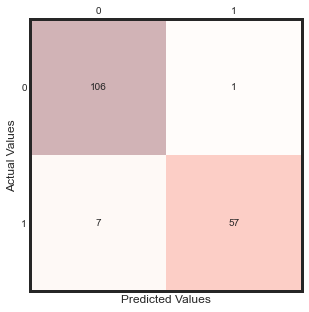

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       107
           1       0.98      0.89      0.93        64

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Image, display

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()
print(classification_report(y_test, y_pred ))

#### Observation 
There are two possible predicted classes: "1" and "0". Malignant = 1 (indicates prescence of cancer cells) and Benign
= 0 (indicates abscence).

* The classifier made a total of 174 predictions (i.e 174 patients were being tested for the presence breast cancer).
* Out of those 174 cases, the classifier predicted "yes" 58 times, and "no" 113 times.
* In reality, 64 patients in the sample have the disease, and 107 patients do not.

#### Rates as computed from the confusion matrix
1. **Accuracy**: Overall, how often is the classifier correct?
    * (TP+TN)/total = (57+106)/171 = 0.95

2. **Misclassification Rate**: Overall, how often is it wrong?
    * (FP+FN)/total = (1+7)/171 = 0.05 equivalent to 1 minus Accuracy also known as ***"Error Rate"***

3. **True Positive Rate:** When it's actually yes, how often does it predict 1?
   * TP/actual yes = 57/64 = 0.89 also known as "Sensitivity" or ***"Recall"***

4. **False Positive Rate**: When it's actually 0, how often does it predict 1?
   * FP/actual no = 1/107 = 0.01

5. **Specificity**: When it's actually 0, how often does it predict 0? also know as **true positive rate**
   * TN/actual no = 106/107 = 0.99 equivalent to 1 minus False Positive Rate

6. **Precision**: When it predicts 1, how often is it correct?
   * TP/predicted yes = 57/58 = 0.98

7. **Prevalence**: How often does the yes condition actually occur in our sample?
   * actual yes/total = 64/171 = 0.34



<ipython-input-11-f22080c8d866>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


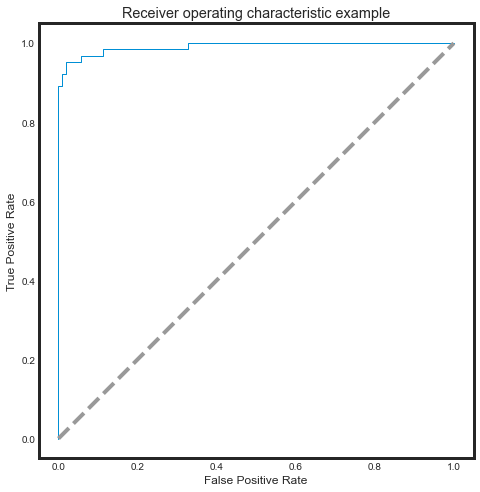

In [11]:
from sklearn.metrics import roc_curve, auc
# Plot the receiver operating characteristic curve (ROC).
plt.figure(figsize=(10,8))
probas_ = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.axes().set_aspect(1)

* To interpret the ROC correctly, consider what the points that lie along the diagonal represent. For these situations, there is an equal chance of "+" and "-" happening. Therefore, this is not that different from making a prediction by tossing of an unbiased coin. Put simply, the classification model is random.

* For the points above the diagonal, tpr > fpr, and the model says that you are in a zone where you are performing better than random. For example, assume tpr = 0.99 and fpr = 0.01, Then, the probability of being in the true positive group is $(0.99 / (0.99 + 0.01)) = 99\%$. Furthermore, holding fpr constant, it is easy to see that the more vertically above the diagonal you are positioned, the better the classification model.

## Next I will look into optimizing the clas

1. Cortes, Corinna, and Vladimir Vapnik. 1995. “Support-Vector Networks.” Machine Learning 20: 273. Accessed September 3, 2016. doi: 10.1023/A:1022627411411.
